**Final Project Computer Vision**

**Kelompok 10**

Anggota Kelompok:

Nama  : Rio Pramana, Debora

NIM   : 2440016804, 2440087214

Kelas : LA01

Although there are comments in the notebook that will explain some of the code, most of the explanations for the code are provided in the paper

# Import libraries

In [1]:
from keras import Sequential, callbacks
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from scipy.spatial import distance
import os
import matplotlib.pyplot as plt

# Initialize parameters

In [2]:
resized_dim = 128 # resize image menjadi 128 x 128
batch_size = 16 # menggunakan batch size 16 untuk mini-batch learning
n_features = 64 # Output features layer pertama
nb_classes = 2  # Jumlah class yang akan di predict ada 2, yaitu 'WithMask' & 'WithoutMask'
epochs = 40 # Jumlah maximum epochs yang akan digunakan untuk training model

# Arsitektur
kernel_size = (3, 3) # Size kernel
dropout_p = 0.3 # Probability dropout

#Load train and test set
train_dir = './Train'
test_dir = './Test'
val_dir = './Validation'

# Load Data & Data Augmentation

Pada keras, terdapat ImageDataGenerator yang dapat melakukan preprocessing dan augmentasi data pada data-data images yang kita miliki

ImageDataGenerator ini juga sekaligus bisa digunakan untuk melakukan splitting test set dan validation set

Maka, kedua proses tersebut saya jadikan 1 pada code block dibawah ini

Augmentasi data hanya boleh dilakukan untuk train set saja

Maka, untuk train set saya terapkan beberapa seperti 20% shear range dan zoom range serta horizontal flip

Kemudian rescale dilakukan untuk seluruh dataset agar scalenya menjadi 0 - 1

Untuk training validation test split, dilakukan split menjadi rasio 80-10-10

In [3]:
# Data augmentation

train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    horizontal_flip=True, #randomly flip images horizontally
    zoom_range=0.2, #randomly zoom image
    shear_range=0.2 
)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(resized_dim,resized_dim), #resize image menjadi 128 x 128
    class_mode='categorical',
    batch_size=batch_size,
    seed = 42,
    shuffle = True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(resized_dim,resized_dim),
    class_mode='categorical',
    batch_size=batch_size,
    seed = 42,
    shuffle = False
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(resized_dim,resized_dim),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

Found 10000 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.


# Building the model

In [4]:
model = Sequential()

# Conv2D pertama + activation relu
model.add(Conv2D(n_features, kernel_size, input_shape=[resized_dim, resized_dim, 3], padding='same', activation='relu'))
# MaxPooling2D pertama
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_p))
n_features /= 2 # Bagi n_features dengan 2

# Conv2D kedua + activation relu
model.add(Conv2D(n_features, kernel_size, padding='same', activation='relu'))
model.add(BatchNormalization())
# MaxPooling2D kedua
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_p))
n_features /= 2

# Conv2D ketiga + activation relu
model.add(Conv2D(n_features, kernel_size, activation='relu'))
model.add(BatchNormalization())
# MaxPooling2D ketiga
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_p))

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_p))
model.add(Dense(nb_classes, activation='softmax'))

optim = Adam(learning_rate=0.01)
model.compile(optimizer=optim,loss="categorical_crossentropy",metrics ="accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       1

# Training the model while avoiding overfitting

In [5]:
train_steps = len(train_generator)//batch_size
val_steps = len(val_generator)//batch_size

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 4, 
                                        restore_best_weights = True, verbose=1,
                                       start_from_epoch = 5)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = val_generator, 
    validation_steps = val_steps,
    epochs = epochs,
    callbacks = [earlystopping]
  )

Epoch 1/40
39/39 [==============================] - 20s 484ms/step - loss: 1.1539 - accuracy: 0.7644 - val_loss: 0.2105 - val_accuracy: 0.9375
Epoch 2/40
39/39 [==============================] - 19s 468ms/step - loss: 0.4717 - accuracy: 0.8670 - val_loss: 0.9786 - val_accuracy: 0.2812
Epoch 3/40
39/39 [==============================] - 20s 502ms/step - loss: 0.3034 - accuracy: 0.8462 - val_loss: 0.4582 - val_accuracy: 0.7812
Epoch 4/40
39/39 [==============================] - 21s 523ms/step - loss: 0.2530 - accuracy: 0.9151 - val_loss: 3.6230 - val_accuracy: 0.5000
Epoch 5/40
39/39 [==============================] - 20s 503ms/step - loss: 0.2364 - accuracy: 0.9279 - val_loss: 0.6488 - val_accuracy: 0.8281
Epoch 6/40
39/39 [==============================] - 20s 506ms/step - loss: 0.3492 - accuracy: 0.9022 - val_loss: 0.1618 - val_accuracy: 0.9531
Epoch 7/40
39/39 [==============================] - 20s 508ms/step - loss: 0.2660 - accuracy: 0.8974 - val_loss: 0.1578 - val_accuracy: 0.9375

# Plotting the training & validation accuracy and loss

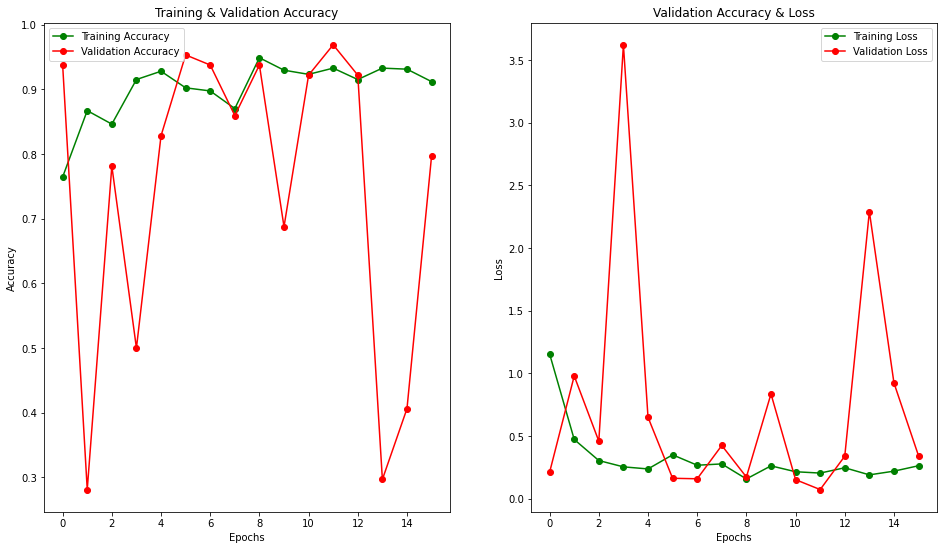

In [6]:
list_epochs = [i for i in range(len(history.history['val_loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(list_epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(list_epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(list_epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(list_epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Validation Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Evaluate model on the test dataset

In [7]:
test_steps = len(test_generator)//batch_size

score =  model.evaluate(test_generator, steps=test_steps)
print('Loss: ', score[0])
print('Accuracy: ', score[1])

4/4 [==============================] - 0s 93ms/step - loss: 0.0029 - accuracy: 1.0000
Loss:  0.0029333739075809717
Accuracy:  1.0


# Evaluate model on 'WithMask' only dataset & 'WithoutMask' only dataset

In [8]:
test_mask_dir = './Test All Mask'

test_mask_datagen = ImageDataGenerator(rescale=1.0/255)
test_mask_generator = test_mask_datagen.flow_from_directory(
    directory=test_mask_dir,
    target_size=(resized_dim,resized_dim),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

test_mask_steps = len(test_mask_generator)//batch_size

mask_score =  model.evaluate(test_mask_generator, steps=test_mask_steps)
print('')
print('Loss (Only mask): ', mask_score[0])
print('Accuracy (Only mask): ', mask_score[1])
print('')

test_nomask_dir = './Test No Mask'

test_nomask_datagen = ImageDataGenerator(rescale=1.0/255)
test_nomask_generator = test_nomask_datagen.flow_from_directory(
    directory=test_nomask_dir,
    target_size=(resized_dim,resized_dim),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle = False
)

test_nomask_steps = len(test_nomask_generator)//batch_size

nomask_score =  model.evaluate(test_nomask_generator, steps=test_nomask_steps)
print('')
print('Loss (Only no mask): ', nomask_score[0])
print('Accuracy (Only no mask): ', nomask_score[1])
print('')

print('Average Accuracy: ', (mask_score[1] + nomask_score[1]) / 2.0)

Found 625 images belonging to 2 classes.
2/2 [==============================] - 0s 111ms/step - loss: 0.0053 - accuracy: 1.0000

Loss (Only mask):  0.005327431485056877
Accuracy (Only mask):  1.0

Found 625 images belonging to 2 classes.
2/2 [==============================] - 0s 119ms/step - loss: 0.1614 - accuracy: 1.0000

Loss (Only no mask):  0.16138942539691925
Accuracy (Only no mask):  1.0

Average Accuracy:  1.0


# Saving the model using pickle

In [2]:
import pickle
with open("final_model.pkl", "wb") as f:
  pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\dropout_3
......vars
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                  